In [ ]:
from typing import Literal
import numpy as np
import pandas as pd
import logging  # For potential logging, if needed
from tqdm import tqdm  # For progress bars
from dtaidistance import dtw  # For Dynamic Time Warping

# Define type hints for clarity
DISTANCE_METRICS = Literal["euclidean", "manhattan", "dtw"]
INIT_METHOD = Literal["random", "kmeans++"]


class MyKMeans:
    """
    Custom K-means clustering implementation with support for multiple distance metrics.

    Args:
        k (int): Number of clusters.
        max_iter (int, optional): Maximum number of iterations. Defaults to 100.
        distance_metric (str, optional): Distance metric to use. Options are "euclidean",
                                         "manhattan", or "dtw". Defaults to "euclidean".
        init_method (str, optional): Initialization method to use. Options are "kmeans++" or "random". Defaults to "kmeans++".
    """

    def __init__(self,
                 k: int,
                 max_iter: int = 100,
                 distance_metric: DISTANCE_METRICS = "euclidean",
                 init_method: INIT_METHOD = "kmeans++"
                 ):
        self.k: int = k
        self.max_iter: int = max_iter
        self.distance_metric: DISTANCE_METRICS = distance_metric
        self.centroids: np.ndarray | None = None
        self.inertia_: float | None = None
        self.labels_: np.ndarray | None = None  # Cluster labels for each point
        self.init_method: INIT_METHOD = init_method

    def _initialize_centroids(self, x: np.ndarray) -> np.ndarray:
        """
        Initialize centroids based on the chosen init_method.

        Args:
            x (np.ndarray): Training data of shape (n_samples, n_features) or (n_samples, time_steps, n_features_ts).

        Returns:
            np.ndarray: Initialized centroids.
        """
        n_samples = x.shape[0]

        if self.init_method == "random":
            rng = np.random.default_rng(42)
            # Select k unique random samples as initial centroids
            random_indices = self.rng.choice(
                n_samples, size=self.k, replace=False)
            centroids = x[random_indices].copy()

        elif self.init_method == "kmeans++":
            # (k, n_features) or (k, time_steps, n_features_ts)
            centroids = np.empty((self.k,) + x.shape[1:], dtype=x.dtype)

            # 1. Choose the first centroid randomly from the data points
            rng = np.random.default_rng(42)

            # Select k unique random samples as initial centroids
            first_centroid_idx = rng.choice(n_samples)
            centroids[0] = x[first_centroid_idx].copy()

            # For the remaining k-1 centroids
            for i in range(1, self.k):

                # For each data point, find the squared distance to the nearest *already chosen* centroid
                distances_to_chosen_centroids = self._compute_distance(
                    x, centroids[:i])
                min_squared_distances = np.min(
                    distances_to_chosen_centroids**2, axis=1)

                # 2b. Select the next centroid with probability proportional to D(x)^2
                # Avoid division by zero if all points are identical to centroids
                if np.sum(min_squared_distances) == 0:
                    # Fallback to random sampling if all distances are zero
                    probabilities = np.ones(n_samples) / n_samples
                else:
                    probabilities = min_squared_distances / \
                        np.sum(min_squared_distances)

                rng = np.random.default_rng(42)
                next_centroid_idx = rng.choice(
                    n_samples, p=probabilities)
                centroids[i] = x[next_centroid_idx].copy()
        else:
            raise ValueError(
                f"Unknown initialization method: {self.init_method}")

        return centroids

    def _compute_distance(self, x: np.ndarray, centroids: np.ndarray) -> np.ndarray:
        """
        Compute the distance between each sample in x and each centroid.

        Args:
            x (np.ndarray): Data points. Shape (n_samples, n_features) for 2D data,
                            or (n_samples, time_steps, n_features_ts) for 3D time series data.
            centroids (np.ndarray): Current centroids. Shape (k, n_features) for 2D data,
                                    or (k, time_steps, n_features_ts) for 3D time series data.

        Returns:
            np.ndarray: Distances of shape (n_samples, k).
        """
        n_samples = x.shape[0]
        k_centroids = centroids.shape[0]
        distances = np.empty((n_samples, k_centroids), dtype=np.float64)

        if self.distance_metric == "euclidean":
            if x.ndim == 2:
                for i in range(k_centroids):
                    distances[:, i] = np.linalg.norm(x - centroids[i], axis=1)
            # Time series data
            elif x.ndim == 3:
                # Reshape for broadcasting: x (N,1,T,F), centroids (1,K,T,F)
                diff = x[:, np.newaxis, :, :] - centroids[np.newaxis, :, :, :]
                distances = np.linalg.norm(diff, axis=(2, 3))
            else:
                raise ValueError(
                    "Euclidean distance supports 2D or 3D input data.")

        elif self.distance_metric == "manhattan":
            if x.ndim == 2:
                for i in range(k_centroids):
                    distances[:, i] = np.sum(np.abs(x - centroids[i]), axis=1)

            elif x.ndim == 3:  # (n_samples, time_steps, n_features_ts)
                diff = x[:, np.newaxis, :, :] - centroids[np.newaxis, :, :, :]
                distances = np.sum(np.abs(diff), axis=(2, 3))

            else:  #
                raise ValueError(
                    "Manhattan distance supports 2D or 3D input data.")

        elif self.distance_metric == "dtw":
            distances = self._dtw(x, centroids)

        else:
            raise ValueError(
                f"Unsupported distance metric: {self.distance_metric}")

        return distances

    def _dtw(self, x: np.ndarray, centroids: np.ndarray) -> np.ndarray:
        """
        Simplified DTW distance computation using dtaidistance.

        Args:
            x (np.ndarray): Data points of shape (n_samples, time_steps, n_features) or (n_samples, n_features)
            centroids (np.ndarray): Centroids of shape (k, time_steps, n_features) or (k, n_features)

        Returns:
            np.ndarray: DTW distances between each sample and each centroid, shape (n_samples, k).
        """

        n_samples = x.shape[0]
        k_centroids = centroids.shape[0]
        dtw_distances = np.empty((n_samples, k_centroids), dtype=np.float64)

        # Prepare data: ensure 3D for consistent processing (N, T, F)
        # If input is 2D (N, T), treat as (N, T, 1)
        x_proc = x if x.ndim == 3 else x[:, :, np.newaxis]
        centroids_proc = centroids if centroids.ndim == 3 else centroids[:, :, np.newaxis]

        if x_proc.shape[2] != centroids_proc.shape[2]:  # Check feature consistency
            raise ValueError(
                "DTW: x and centroids must have the same number of features.")

        n_features_ts = x_proc.shape[2]

        for i in range(n_samples):
            for j in range(k_centroids):
                sample_ts_multivar = x_proc[i]      # (T, F_ts)
                centroid_ts_multivar = centroids_proc[j]  # (T, F_ts)
                current_total_dtw_dist = 0.0
                for feat_idx in range(n_features_ts):
                    s1 = sample_ts_multivar[:, feat_idx]
                    s2 = centroid_ts_multivar[:, feat_idx]
                    # dtaidistance.dtw.distance_fast is efficient
                    current_total_dtw_dist += dtw.distance_fast(
                        s1, s2, use_pruning=True)
                dtw_distances[i, j] = current_total_dtw_dist
        return dtw_distances

    def fit(self, x: np.ndarray | pd.DataFrame):
        """
        Fit the K-means model to the data.

        Args:
            x (np.ndarray | pd.DataFrame): Training data of shape (n_samples, n_features).

        Returns:
            MyKMeans: Fitted estimator instance.
        """
        if isinstance(x, pd.DataFrame):
            x = x.to_numpy()
        elif isinstance(x, np.ndarray):
            pass
        else:
            raise ValueError(
                "Input data must be a numpy array or a pandas DataFrame")

        # Add dimension check after type conversion and before other operations
        if not (x.ndim == 2 or x.ndim == 3):
            raise ValueError("Input data must be a 2D or 3D array")
        if x.shape[0] < self.k:
            raise ValueError(
                f"Number of samples ({x.shape[0]}) must be at least k ({self.k}).")

        self.centroids = self._initialize_centroids(x)

        # Use tqdm for progress bar
        for iteration in tqdm(range(self.max_iter), desc="K-Means Iterations", leave=False):
            old_centroids = self.centroids.copy()

            # 1. Assignment step: Assign samples to the closest centroid
            distances = self._compute_distance(x, self.centroids)
            self.labels_ = np.argmin(distances, axis=1)

            # 2. Update step: Recalculate centroids
            new_centroids = np.empty_like(self.centroids)
            for i in range(self.k):
                cluster_points = x[self.labels_ == i]
                if len(cluster_points) > 0:
                    new_centroids[i] = np.mean(cluster_points, axis=0)
                else:
                    # Handle empty cluster
                    logging.warning(
                        f"Cluster {i} became empty at iteration {iteration}.")

                    rng = np.random.default_rng(42)
                    new_centroids[i] = x[rng.choice(
                        x.shape[0])].copy()

            self.centroids = new_centroids

            if np.allclose(old_centroids, self.centroids):
                logging.info(f"Converged at iteration {iteration+1}.")
                break
        else:
            logging.info(
                f"K-Means did not converge within {self.max_iter} iterations.")

        final_distances_to_assigned_centroids = self._compute_distance(
            x, self.centroids)
        min_distances = np.min(final_distances_to_assigned_centroids, axis=1)

        if self.distance_metric in ["euclidean", "manhattan"]:
            self.inertia_ = np.sum(min_distances**2)
        elif self.distance_metric == "dtw":
            self.inertia_ = np.sum(min_distances)

        return self

    def predict(self, x: np.ndarray):
        """
        Predict the closest cluster for each sample in x.

        Args:
            x (np.ndarray): New data to predict, of shape (n_samples, n_features).

        Returns:
            np.ndarray: Index of the cluster each sample belongs to.
        """
        # Compute distances between samples and centroids
        distances = self._compute_distance(x, self.centroids)

        # Return the index of the closest centroid for each sample
        return np.argmin(distances, axis=1)

    def fit_predict(self, x: np.ndarray):
        """
        Fit the K-means model to the data and return the predicted labels.
        """
        if isinstance(x, pd.DataFrame):
            x = x.values
        elif isinstance(x, np.ndarray):
            pass
        else:
            raise ValueError(
                "Input data must be a numpy array or a pandas DataFrame")
        self.fit(x)
        return self.predict(x)


In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

from tqdm import tqdm

from ex_01_read_data import get_welding_data
from ex_03_feature_extraction import extract_features
from ex_04_my_kmeans import MyKMeans
from sklearn.preprocessing import StandardScaler 


In [5]:
data_path = Path("data/Welding/data.csv")
plot_path = Path("plots/ex_04")
plot_path.mkdir(parents=True, exist_ok=True)


data, labels, exp_ids = get_welding_data(data_path, n_samples=5_000)

4.6 und 4.7 nicht gelöst

## Exercise 4.2: Optimal Cluster Selection

Implement the elbow method to find the optimal number of clusters for the raw time series data using your implement of the kmeans algorithm (MyKMeans).

1. Calculate the distortion (inertia) for different values of k (1 to 10)
2. Plot the results to identify the "elbow point" with matplotlib where adding more clusters produces diminishing returns
3. This will help determine the most appropriate number of clusters for our welding data

Running MyKMeans for k=1 to 10 using euclidean distance for elbow method...


Elbow Method (euclidean) Progress: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it]


Elbow plot saved to plots\ex_04\elbow_raw_ts_euclidean.png


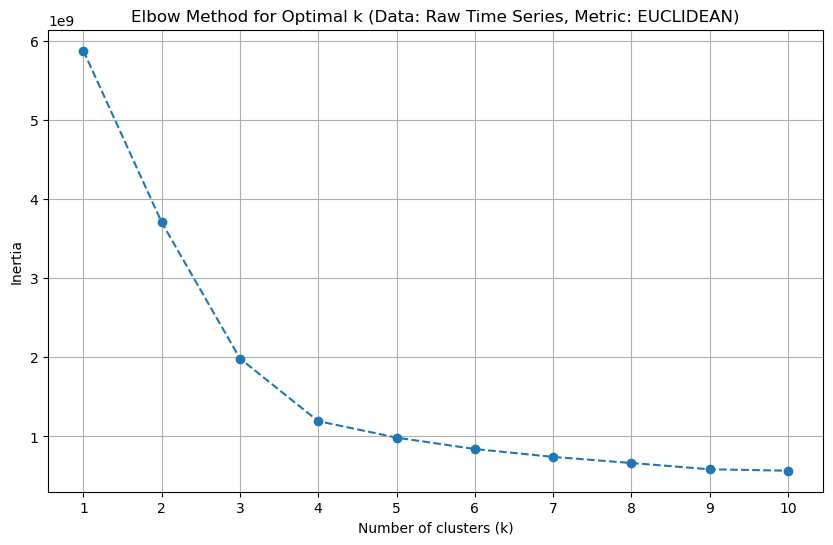

[5874484697.888531,
 3706446322.4635305,
 1985457477.685868,
 1193948906.3530247,
 985909603.7023098,
 841656010.4472415,
 742296464.7622337,
 665027694.7354708,
 585797594.3597456,
 567526517.6009274]

In [6]:

def elbow_method(X, max_clusters=10, distance_metric="euclidean"):
    """
    Apply the elbow method to find the optimal number of clusters.
    
    Args:
        X: Feature matrix (scaled)
        max_clusters: Maximum number of clusters to try
        distance_metric: Distance metric to use
    """
    if X is None or X.size == 0:
        print(f"No data provided for elbow method with metric")
        return None 
        
    inertias = []
    k_range = range(1, max_clusters + 1)
    
    print(f"Running MyKMeans for k=1 to {max_clusters} using {distance_metric} distance for elbow method...")

    for k_val in tqdm(k_range, desc=f"Elbow Method ({distance_metric}) Progress"):
        kmeans = MyKMeans(k=k_val, distance_metric=distance_metric, max_iter=50) 
        try:
            kmeans.fit(X)
            if kmeans.inertia_ is not None:
                inertias.append(kmeans.inertia_)
            else:
                print(f"Warning: Inertia is None for k={k_val} with {distance_metric} distance.")
                inertias.append(np.nan) 
        except Exception as e:
            print(f"Error running MyKMeans for k={k_val} with {distance_metric}: {e}.")
            inertias.append(np.nan)

    # Plotting the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, marker='o', linestyle='--')
    plt.title(f'Elbow Method for Optimal k (Data: Raw Time Series, Metric: {distance_metric.upper()})')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(list(k_range))
    plt.grid(True)
    
    elbow_plot_filename = f"elbow_raw_ts_{distance_metric}.png"
    elbow_plot_path = plot_path / elbow_plot_filename
    plt.savefig(elbow_plot_path)
    print(f"Elbow plot saved to {elbow_plot_path}")
    plt.show()
    return inertias

elbow_method(data)

## Exercise 4.3: Clustering with MyKMeans

### Based on the elbow curve above, explain your choice of k:

1. What does the shape of the elbow curve tell you about the underlying data structure?
2. Why did you select this specific number of clusters?
   - Consider the plot and the elbow method to justify your choice
   - How might this choice affect the interpretability of the resulting clusters?

### KMeans with euclidean distance and dtw distance
1. run K means with you selected k 


1. The curve shows a sharp initial drop in inertia, then flattens, suggesting a few distinct underlying groups in the data. 
2. I'd select  k=4. This is where the "elbow" or most significant bend occurs, after which adding more clusters gives much smaller improvements in inertia. \
 -Choosing k = 3 likely yields broader, more distinct, and easier-to-interpret clusters. More clusters might over-segment and make distinctions less clear.

In [7]:
k = 4
if data is not None:
    print(f"\nRunning MyKMeans with k={k} and Euclidean distance .")
    kmeans_euclidean_ts = MyKMeans(k=k, distance_metric="euclidean") 
    cluster_labels_euclidean_ts = kmeans_euclidean_ts.fit_predict(data)
    print(f"Euclidean Clustering {kmeans_euclidean_ts.inertia_}")

    print(f"\nRunning MyKMeans with k={k} and DTW distance  .")
    kmeans_dtw_ts = MyKMeans(k=k, distance_metric="dtw") # Removed random_state
    cluster_labels_dtw_ts = kmeans_dtw_ts.fit_predict(data)
    print(f"DTW Clustering (Raw TS) - Inertia: {kmeans_dtw_ts.inertia_}")
else:
    print("Skipping K-Means on raw time series due to data loading issues.")



Running MyKMeans with k=4 and Euclidean distance .


Euclidean Clustering 1193948906.3530247

Running MyKMeans with k=4 and DTW distance  .


DTW Clustering (Raw TS) - Inertia: 663728.2969202667


## Exercise 4.4: Cluster Visualization

Plot the mean time series (centroids) for each cluster to visualize and understand the patterns.

Remember that our welding data has both current and voltage measurements over time (shape: n_samples, sequence_length, features). For each cluster:
1. Plot the average current pattern
2. Plot the average voltage pattern
3. Look for distinctive characteristics in each cluster that might relate to welding quality

This visualization will help identify what makes each cluster unique in terms of temporal patterns.

Centroid plot saved to plots\ex_04\centroids_ts_k4_euclidean_raw_ts.png


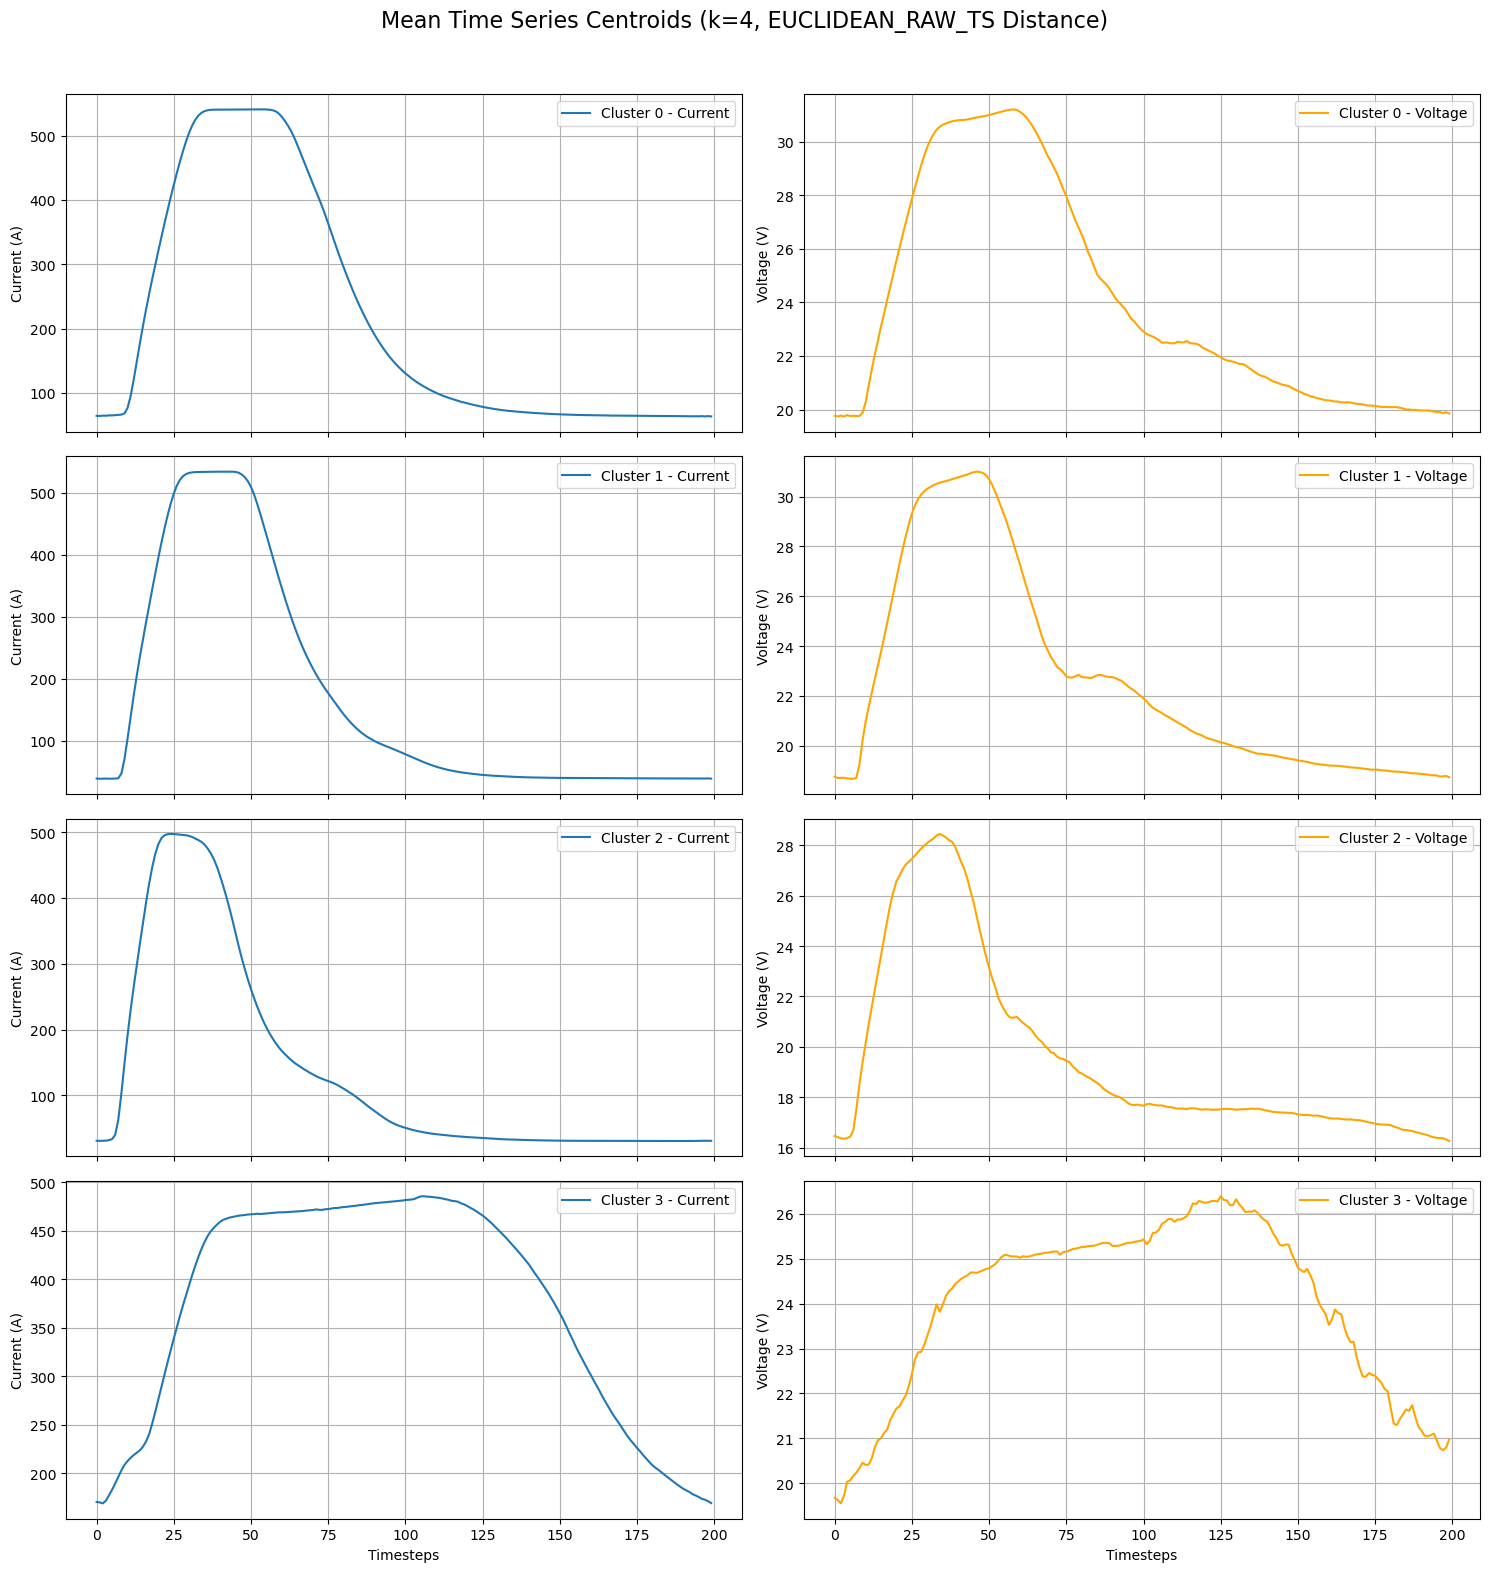

Centroid plot saved to plots\ex_04\centroids_ts_k4_dtw_raw_ts.png


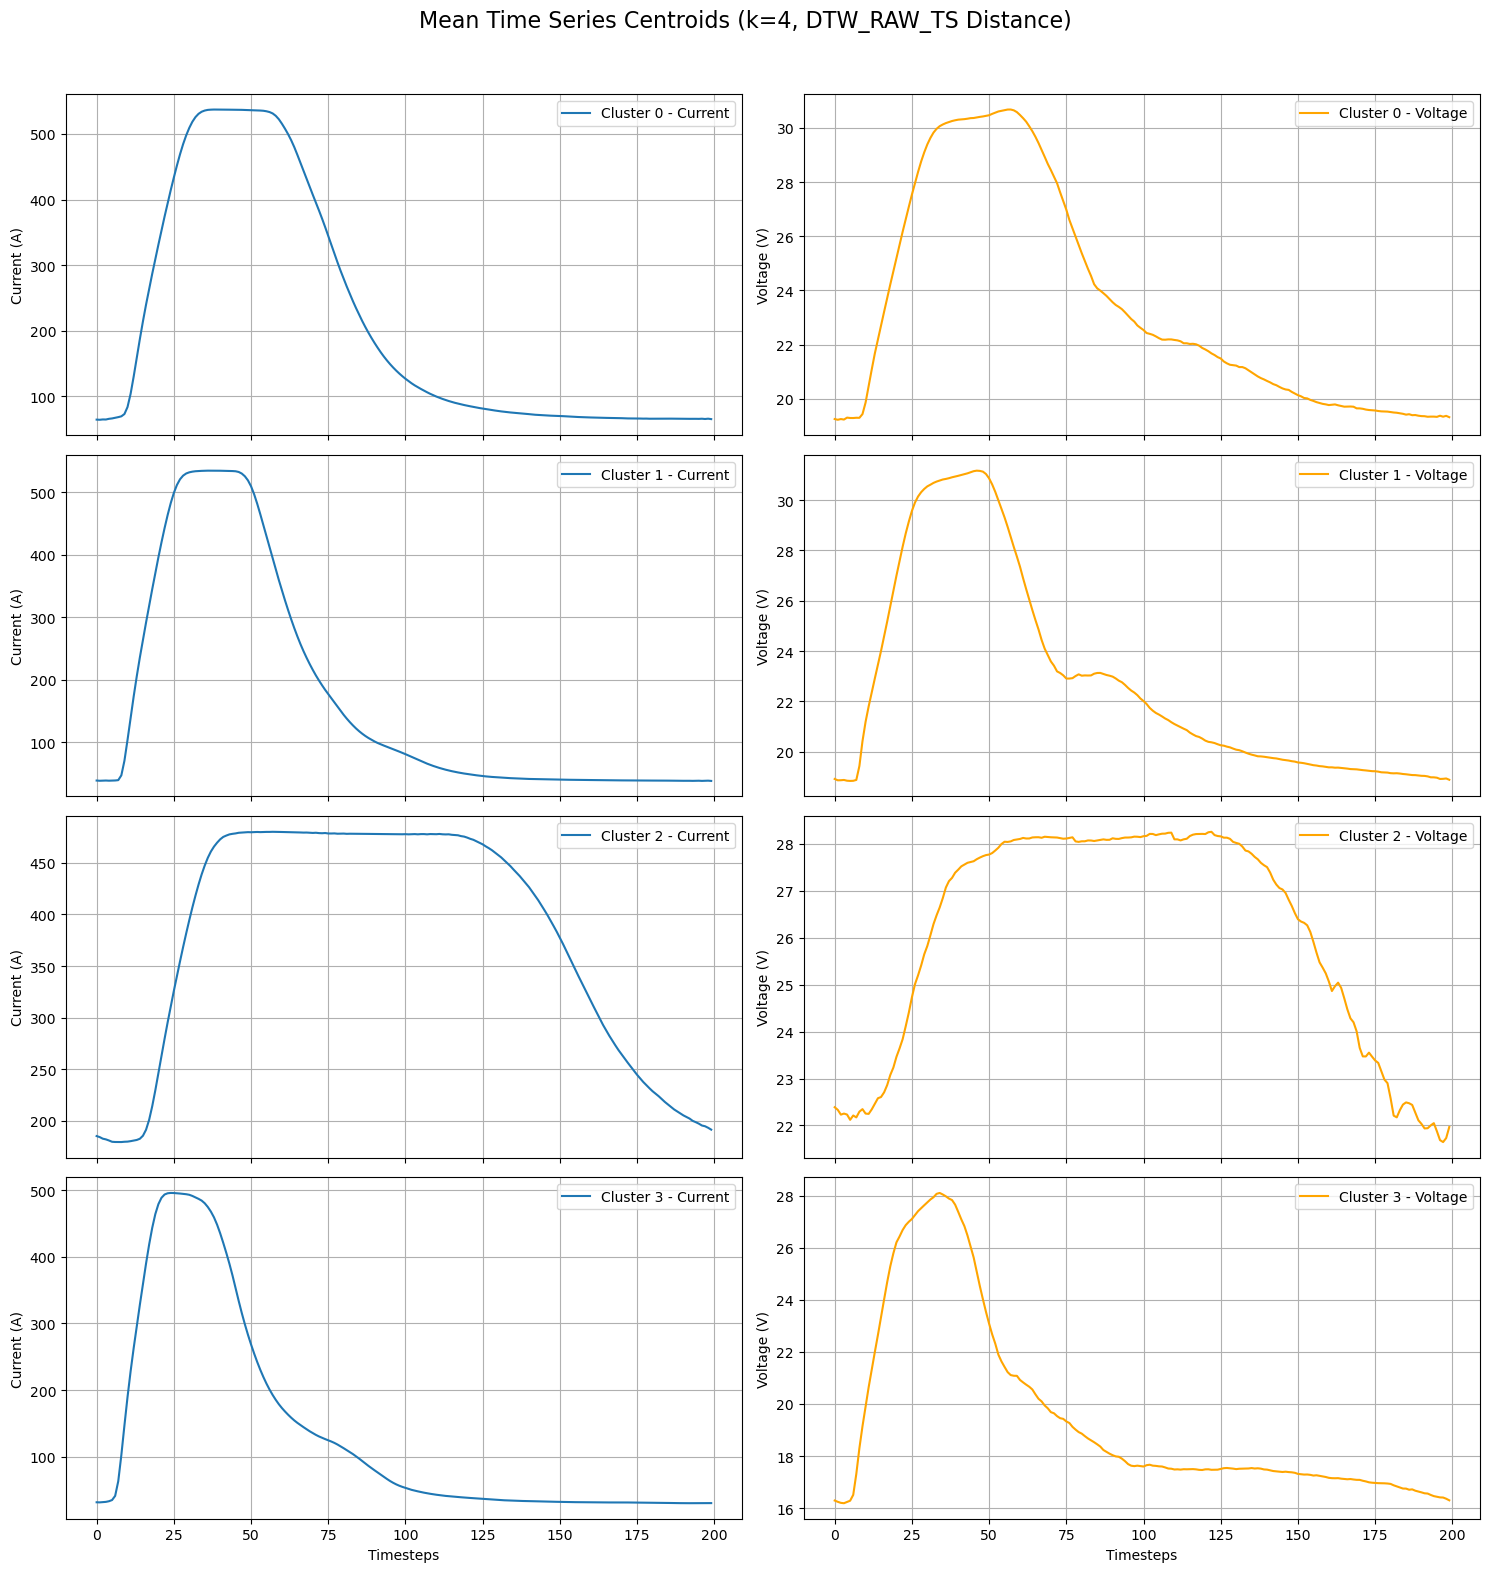

In [8]:
def plot_ts_centroids(centroids: np.ndarray, k_val: int, distance_metric_name: str):

    if centroids is None or centroids.shape[0] != k_val:
        print(f"Cannot plot centroids for {distance_metric_name}.")
        return

    n_timesteps = centroids.shape[1]
    n_features_ts = centroids.shape[2] # Should be 2 (Current, Voltage)
    
    if n_features_ts != 2:
        print(f"Warning: Expected 2 features (Current, Voltage) in centroids, found {n_features_ts}.")

    fig, axes = plt.subplots(k_val, n_features_ts, figsize=(15, k_val * 4), sharex=True)

    fig.suptitle(f'Mean Time Series Centroids (k={k_val}, {distance_metric_name.upper()} Distance)', fontsize=16)
    time_axis = np.arange(n_timesteps)

    for i in range(k_val):
        if n_features_ts > 0 :
            axes[i, 0].plot(time_axis, centroids[i, :, 0], label=f'Cluster {i} - Current')
            axes[i, 0].set_ylabel('Current (A)')
            axes[i, 0].legend(loc='upper right')
            axes[i, 0].grid(True)
        
        # Plot Voltage (feature 1)
        if n_features_ts > 1:
            axes[i, 1].plot(time_axis, centroids[i, :, 1], label=f'Cluster {i} - Voltage', color='orange')
            axes[i, 1].set_ylabel('Voltage (V)')
            axes[i, 1].legend(loc='upper right')
            axes[i, 1].grid(True)
        
        if i == k_val - 1 : # Set x-label only for the last row
             if n_features_ts > 0: axes[i,0].set_xlabel('Timesteps')
             if n_features_ts > 1: axes[i,1].set_xlabel('Timesteps')


    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    centroids_plot_path = plot_path / f"centroids_ts_k{k_val}_{distance_metric_name}.png"
    plt.savefig(centroids_plot_path)
    print(f"Centroid plot saved to {centroids_plot_path}")
    plt.show()

if  kmeans_euclidean_ts.centroids is not None:
    plot_ts_centroids(kmeans_euclidean_ts.centroids, k, "euclidean_raw_ts")
if  kmeans_dtw_ts.centroids is not None:
    plot_ts_centroids(kmeans_dtw_ts.centroids, k, "dtw_raw_ts")



## Exercise 4.5: Feature-Based Clustering

Now we'll use the engineered features extracted in Exercise 3 instead of raw time series data. Therefore, you can use the euclidean distance metric.

1. Load your extracted features from exercise 3 
2. Split them into data and labels
3. Scale the data for better clustering performance
4. Apply the elbow method again to determine the optimal number of clusters for the feature-based approach
5. Compare this result with the clustering of raw time series data. Consider why the optimal k might differ between the two approaches:
   - Do engineered features represent the data differently?
   - Which approach might better capture the relevant patterns for quality assessment?


Scaling features...
Engineered features prepared. Shape: (5000, 20)

Calculating elbow curve with Euclidean distance for engineered features...
Running MyKMeans for k=1 to 10 using euclidean distance for elbow method...


Elbow Method (euclidean) Progress: 100%|██████████| 10/10 [00:00<00:00, 19.51it/s]


Elbow plot saved to plots\ex_04\elbow_raw_ts_euclidean.png


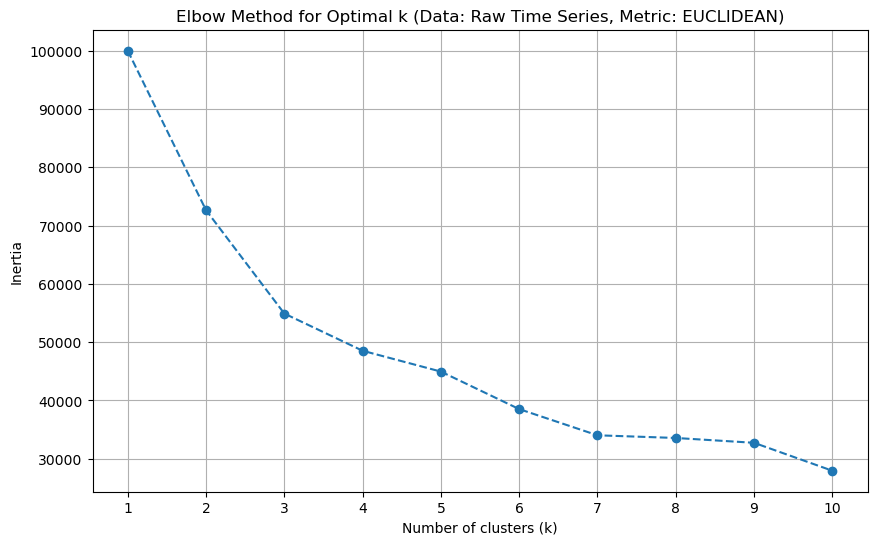

In [9]:
# Extract features from the data
features = extract_features(data, labels)
try:    
    y_true_features = features['label'].copy() # Original quality labels
    X_features = features.drop(columns=['label']).copy()
    
    if X_features.isnull().any().any():
        print(f"Features DataFrame contains NaNs. Shape before drop: {X_features.shape}")
        original_len = len(X_features)
        X_features.dropna(inplace=True)
        y_true_features = y_true_features[X_features.index] 
        print(f"Shape after dropna: {X_features.shape}. Dropped {original_len - len(X_features)} rows.")

    print("Scaling features...")
    scaler = StandardScaler() 
    X_features_scaled = scaler.fit_transform(X_features)
    
    print(f"Engineered features prepared. Shape: {X_features_scaled.shape}")

    # Apply elbow method for feature-based approach
    print("\nCalculating elbow curve with Euclidean distance for engineered features...")
    elbow_inertias_features = elbow_method(X_features_scaled, max_clusters=10, distance_metric="euclidean")


except Exception as e:
    print(f"Error in feature-based clustering: {e}")


5. we notice that the optimal k jumps from 4 to around 7 / 8 :
-Yes. Engineered features summarize time series into specific numerical characteristics, changing the data's structure and potentially altering the number clusters compared to raw temporal shapes. \
Raw Time Series might be a better approach: capture complex temporal dynamics that simple features miss, especially with a suitable distance metric like DTW.

## Exercise 4.6: Advanced 3D Visualization

Visualize the clustering results using interactive 3D plots with Plotly.

1. Use PCA to reduce the dimensionality of our feature space to 3 components
2. Create two visualizations:
   - Points colored by assigned cluster
   - Same points colored by actual quality labels
3. Include the explained variance for each principal component in the axis labels
4. Save the figures to the plot_path


This visualization will help us understand how well our clustering approach aligns with the known quality designations.

#### Note:
- You can use the following links to find more information about the PCA:
   - https://en.wikipedia.org/wiki/Principal_component_analysis
   - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


In [10]:
#fig1_save_path = save_plotly_figure_as_html(fig1, output_dir / f'clusters_3d_{n_clusters}_clusters')
#fig2_save_path = save_plotly_figure_as_html(fig2, output_dir / f'quality_3d_{n_clusters}_clusters')

## Exercise 4.7: Analysis and Interpretation

Analyze the clustering results in depth and discuss their implications:

1. Cluster separation:
   - How well do clusters separate different quality levels?
   - What is the Adjusted Rand Index between clusters and quality labels?
   - Are there clusters that predominantly contain good or bad welds?

2. Feature importance:
   - Which features seem most important for distinguishing clusters?
   - How does the PCA visualization help us understand the data structure?

3. Process insights:
   - What insights could these clusters provide for improving the welding process?
   - Could certain clusters identify specific types of welding issues?

4. Limitations:
   - What are the limitations of using clustering for quality assessment?
   - How might the approach be improved in future iterations?



In [1]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 1.8/150.0 MB 10.1 MB/s eta 0:00:15
   - -------------------------------------- 4.2/150.0 MB 10.5 MB/s eta 0:00:14
   - -------------------------------------- 6.8/150.0 MB 10.8 MB/s eta 0:00:14
   -- ------------------------------------- 8.9/150.0 MB 10.9 MB/s eta 0:00:13
   --- ------------------------------------ 11.3/150.0 MB 10.8 MB/s eta 0:00:13
   --- ------------------------------------ 13.4/150.0 MB 10.8 MB/s eta 0:00:13
   ---- ----------------------------------- 15.5/150.0 MB 10.6 MB/s eta 0:00:13
   ---- ----------------------------------- 17.6/150.0 MB 10.5 MB/s eta 0:00:13
   ----- ---------------------------------- 19.9/150.0 MB 10.5 MB/s eta 0:00:13
   ----- ---------------------------------- 22.0/150.0 MB 10.6 MB/s eta 0:00:13
   ------ --------------------------------- 24.4/150.0 MB 10.6 MB/s eta 0:00:12
   ------ --------------------------------- 25.4/150.

In [6]:
# In a Jupyter Notebook cell
import numpy as np
import pandas as pd
from pathlib import Path
import warnings

# Import from previous exercises (assuming they are in the src folder)
# Note: You might need to adjust the path depending on your project structure.
import sys

# Scikit-learn and XGBoost imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

warnings.filterwarnings('ignore')

# --- Configuration ---
DATA_PATH = Path("data/Welding/data.csv")
RESULTS_PATH = Path('../results/')
RANDOM_SEEDS = [42, 84, 126]
TEST_SIZE = 0.2
CV_FOLDS = 5

# Create results directory if it doesn't exist
RESULTS_PATH.mkdir(exist_ok=True)

In [20]:
print("Loading and preparing engineered features...")
data_full, labels_full, _ = get_welding_data(DATA_PATH)
features_df = extract_features(data_full, labels_full)


Loading and preparing engineered features...


In [21]:
features_df[features_df['label'] == -1]

,current_mean,current_std,current_median,current_rms,current_min,current_max,current_iqr,current_dom_freq,voltage_mean,voltage_std,...,voltage_rms,voltage_min,voltage_max,voltage_iqr,voltage_dom_freq,power_mean,power_std,power_rms,power_max,label


In [23]:
# In a new Python cell

# --- Data Loading and Preparation ---

# 1. Engineered Features
X_eng = features_df.drop('label', axis=1)
y_eng = features_df['label']

X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(
    X_eng, y_eng, test_size=TEST_SIZE, random_state=RANDOM_SEEDS[0], stratify=y_eng
)

# 2. Raw Time-Series Data
print("Loading and preparing raw time-series data...")
data_raw, labels_raw, _ = get_welding_data(DATA_PATH, return_sequences=False)
# Flatten the data for standard classifiers
n_samples, n_timesteps, n_features = data_raw.shape
X_raw_flat = data_raw.reshape((n_samples, n_timesteps * n_features))
y_raw = labels_raw

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw_flat, y_raw, test_size=TEST_SIZE, random_state=RANDOM_SEEDS[0], stratify=y_raw
)

print(f"Engineered Features - Train shape: {X_train_eng.shape}, Test shape: {X_test_eng.shape}")
print(f"Raw Data (Flattened) - Train shape: {X_train_raw.shape}, Test shape: {X_test_raw.shape}")

Loading and preparing raw time-series data...
Engineered Features - Train shape: (126372, 20), Test shape: (31593, 20)
Raw Data (Flattened) - Train shape: (126372, 400), Test shape: (31593, 400)


In [24]:
# In a new Python cell

# --- Model and Hyperparameter Grid Definition ---

# Define classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Define hyperparameter grids
param_grids = {
    'LogisticRegression': {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__penalty': ['l1', 'l2']
    },
    'SVC': {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': [1, 0.1, 0.01],
        'classifier__kernel': ['rbf']
    },
    'RandomForest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5, 7]
    }
}

In [26]:
# In a new Python cell

def run_evaluation_pipeline(X_train, y_train, X_test, y_test, dataset_name: str):
    """
    Runs the full evaluation pipeline for all classifiers on a given dataset.
    """
    all_results = []

    for name, classifier in classifiers.items():
        print(f"--- Running for {name} on {dataset_name} ---")

        # Create a pipeline with SMOTE, Scaler, and Classifier
        # We handle class imbalance with SMOTE because it creates synthetic samples
        # for the minority class, which can lead to a more robust decision boundary
        # compared to just weighting classes.
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('scaler', StandardScaler()),
            ('classifier', classifier)
        ])

        # Setup GridSearchCV
        grid_search = GridSearchCV(
            pipeline,
            param_grid=param_grids[name],
            cv=CV_FOLDS,
            scoring='f1_weighted', # Use F1-score for tuning on potentially imbalanced data
            n_jobs=-1
        )

        # Find best hyperparameters
        print("Searching for best hyperparameters...")
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        print(f"Best parameters found: {best_params}")

        # Train with best params over multiple seeds and evaluate on the test set
        seed_metrics = []
        for seed in RANDOM_SEEDS:
            # Update random states in the best model pipeline
            final_model = grid_search.best_estimator_
            final_model.set_params(
                **{'smote__random_state': seed, 'classifier__random_state': seed}
            )

            # Train on the full training set
            final_model.fit(X_train, y_train)

            # Evaluate on the held-out test set
            y_pred = final_model.predict(X_test)
            y_proba = final_model.predict_proba(X_test)[:, 1] if hasattr(final_model, "predict_proba") else None

            metrics = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, zero_division=0),
                'recall': recall_score(y_test, y_pred, zero_division=0),
                'f1_score': f1_score(y_test, y_pred, zero_division=0),
                'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
            }
            seed_metrics.append(metrics)

        # Calculate mean and std dev of metrics
        metrics_df = pd.DataFrame(seed_metrics)
        mean_metrics = metrics_df.mean()
        std_metrics = metrics_df.std()

        # Combine results
        result_row = {'model': name}
        for metric in mean_metrics.index:
            result_row[f'{metric}_mean'] = mean_metrics[metric]
            result_row[f'{metric}_std'] = std_metrics[metric]
        all_results.append(result_row)

    # Save results to CSV
    results_df = pd.DataFrame(all_results)
    output_path = RESULTS_PATH / f"ex_05_results_{dataset_name}.csv"
    results_df.to_csv(output_path, index=False)
    print(f"\nResults for {dataset_name} saved to {output_path}")
    return results_df

# --- Run for both datasets ---
results_eng = run_evaluation_pipeline(X_train_eng, y_train_eng, X_test_eng, y_test_eng, "engineered_features")
results_raw = run_evaluation_pipeline(X_train_raw, y_train_raw, X_test_raw, y_test_raw, "raw_data")

--- Running for LogisticRegression on engineered_features ---
Searching for best hyperparameters...
Best parameters found: {'classifier__C': 10.0, 'classifier__penalty': 'l1'}
--- Running for SVC on engineered_features ---
Searching for best hyperparameters...


KeyboardInterrupt: 

In [ ]:
# In a new Python cell to display the results

print("--- Results for Engineered Features ---")
display(results_eng)

print("\n--- Results for Raw Data (Flattened) ---")
display(results_raw)